# WP2
## Author: John D'Angelo
### Fall 2018, University of Texas at Austin

Before we begin, we need to recall the information we derived last time with respect to Depth E.

In [14]:
import numpy as np

depthSpacing_Metric = 25 #meters
depthSpacing_Field = depthSpacing_Metric*3.28084 #ft

#Instead of estimating actual values along the axes of the plot,
#I estimated the spacing between the lines on the plot and converted
#that into values based on the known spacing. 

pressureSpacing = (12000-6000)/5 #psi

stressSpacing = pressureSpacing #psi

PPRS_3_A_Field = 1.25*pressureSpacing #psi
PPRS_3_B_Field = 1.75*pressureSpacing #psi
distanceAB_Field = 8*depthSpacing_Field #meters to feet

porePressureGradientAB_Field = (PPRS_3_B_Field-PPRS_3_A_Field)/distanceAB_Field

#Pore Pressure values at depth E
Pp_E = PPRS_3_A_Field+8.2*depthSpacing_Field*porePressureGradientAB_Field

#Total stress values at depth E
Sv_E = 3*stressSpacing
Shmax_E = 4.5*stressSpacing
Shmin_E = 2.8*stressSpacing

In [15]:
def stressTensor(Sv,Shmax,Shmin):
    sValues = [Sv,Shmax,Shmin]
    sValues = sorted(sValues,reverse=True)
    return np.array([[sValues[0],0,0],
                    [0,sValues[1],0],
                    [0,0,sValues[2]]])

#Principal stress tensor for Depth E
Sp = stressTensor(Sv_E,Shmax_E,Shmin_E)
print("Principal stress tensor for Depth E [psi]:")
print()
print(Sp)

Principal stress tensor for Depth E [psi]:

[[5400.    0.    0.]
 [   0. 3600.    0.]
 [   0.    0. 3360.]]


In [16]:
def classifyRegime(Sv,Shmax,Shmin):
    if(Sv>Shmax and Shmax >Shmmin):
        return "Normal"
    elif(Shmax>Sv and Sv>Shmin):
        return "Strike-Slip"
    elif(Shmax>Shmin and Shmin>Sv):
        return "Reverse"
    else:
        print("Error: Potential issue with stresses provided")
        return "Bad Input"

Regime = classifyRegime(Sv_E,Shmax_E,Shmin_E)
print("Faulting Regime at Depth E: ")
print(Regime)

Faulting Regime at Depth E: 
Strike-Slip


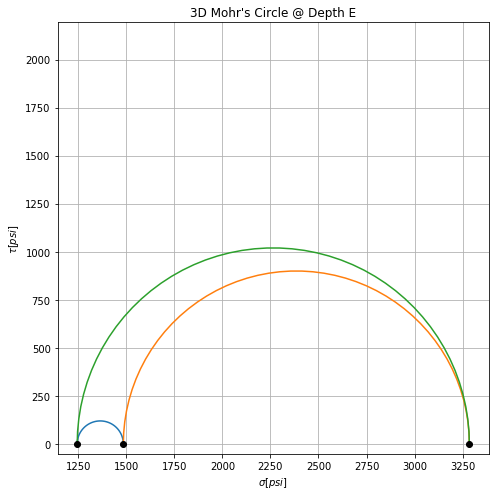

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

#Get effective stress, difference between total stress and pore
#pressure at each depth
sigV=Sv_E-Pp_E
sigHmax=Shmax_E-Pp_E
sigHmin=Shmin_E-Pp_E
#Determine sigma 1,2,3 where sig1>sig2>sig3. Here I used
# a = sig3, b = sig2, c = sig1.
arg = np.array([sigV,sigHmax,sigHmin])
a = np.min(arg)
c = np.max(arg)
arg = arg[np.where(arg!=a)]
arg = arg[np.where(arg!=c)]
b = arg[0]

#Copying and pasting the code for plotting Mohr's circle will get messy really quickly, so let us just
#make a function for convenience

def plotMohr3D(a,b,c):

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    circle1X=[]
    circle1Y=[]
    circle2X=[]
    circle2Y=[]
    circle3X=[]
    circle3Y=[]

    for i in np.linspace(0,np.pi):
        circle1X.append((b-a)/2*np.cos(i) + (a+(b-a)/2))
        circle2X.append((c-b)/2*np.cos(i) + (b+(c-b)/2))
        circle3X.append((c-a)/2*np.cos(i) + (a+(c-a)/2))
        circle1Y.append((b-a)/2*np.sin(i) )
        circle2Y.append((c-b)/2*np.sin(i) )
        circle3Y.append((c-a)/2*np.sin(i) )
    ax.plot(circle1X,circle1Y)
    ax.plot(circle2X,circle2Y)
    ax.plot(circle3X,circle3Y)
    ax.plot([a,b,c],[0,0,0],'ko')
    ax.grid()
    ax.set_xlabel(r'$\sigma [psi]$')
    ax.set_ylabel(r'$\tau [psi]$')
    ax.set_title("3D Mohr's Circle @ Depth E")
    plt.axis('square')
    plt.tight_layout()

    return ax

plotMohr3D(a,b,c)

Part 1, Input the principal stress tensor at Depth E in the principal directions
coordinate system and calculate the tensor in the geographical coordinate
system.

In [18]:
#This task requires a change of basis from the principal coordinate system 
#to the geographical system. This is a common task, so let us make a function
def rotationPG(alpha,beta,gamma,units = "degrees"):
    
    if units.lower().strip().find("deg")!=-1:
        alpha = np.deg2rad(alpha);
        beta = np.deg2rad(beta);
        gamma = np.deg2rad(gamma);
        
    #Easier than calling cos and sin function over and over    
    cA = np.cos(alpha)
    sA = np.sin(alpha)
    cB = np.cos(beta)
    sB = np.sin(beta)
    cG = np.cos(gamma)
    sG = np.sin(gamma)
    
    return np.round(np.array([[cA*cB, sA*cB, -sB],
                    [(cA*sB*sG - sA*cG),(sA*sB*sG+cA*cG), cB*sG ],
                    [(cA*sB*cG + sA*sG),(sA*sB*cG-cA*sG), cB*cG ]]),3)

#We are told that the azimuth of Shmax is 90 deg
azimuthShmax = 90
#We found earlier that this is a Strike-Slip Regime, so alpha beta and
#gamma will be
alpha=azimuthShmax
beta=0
gamma=90

Rot_PG = rotationPG(alpha,beta,gamma)

#Shift Sp to Sg
Sg = np.dot(np.dot(Rot_PG.T,Sp),Rot_PG)
print("Total Stress Tensor in Geographical Coordinate System [psi]")
print()
print(Sg)

Total Stress Tensor in Geographical Coordinate System [psi]

[[3360.    0.    0.]
 [   0. 5400.    0.]
 [   0.    0. 3600.]]


Part 2, Generate 100 randomly distributed fracture orientations (strike and dip) and
compute their effective normal stress and shear stress. Plot all in a σn-τ
diagram together with the 3D Mohr circle(s).

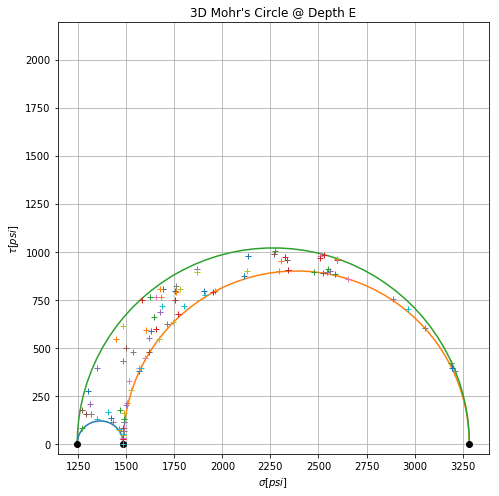

In [19]:
#This task will require a few helpful functions

#Step 1: generate 100 randomly distributed fracture orientations 
#(strike and dip)
# Max dip angle = 90 deg
# Max stirke angle = 180 deg
numSamples = 100

strikeArray = np.random.randint(360, size= numSamples)
dipArray = np.random.randint(90, size=numSamples)

#Step 2: Compute effective normal stress and shear stress

def calcNVectors(strike,dip,units = "degrees"):
    
    if units.lower().strip().find("deg")!=-1:
        strike = np.deg2rad(strike)
        dip = np.deg2rad(dip)

    cS = np.cos(strike)
    sS = np.sin(strike)
    cD = np.cos(dip)
    sD = np.sin(dip)
    nDict = {}
    nDict['n'] = np.array([[-sS*sD, cS*sD, -cD]]).T
    nDict['s'] = np.array([[cS,sS,0]]).T
    nDict['d'] = np.array([[-sS*cD, cS*cD, sD]]).T
    
    return nDict


ax = plotMohr3D(a,b,c)


#Plot all the associated stress values on the Mohr's circle as + symbols
for i in range(0,len(dipArray)):
    nDict = calcNVectors(strikeArray[i],dipArray[i])
    t = np.dot(Sg,nDict['n'])
    Sn = np.dot(nDict['n'].T,t) #Total normal stress
    sign = Sn - Pp_E
    tau = np.sqrt(np.linalg.norm(t,2)**2 - Sn**2)
    ax.plot(sign,tau,'+')
    
# I am not going to lie, I thought it was really cool seeing
# all the randomly generated points land inside the 3D-Mohr's 
# circle contour!

Part 3, Are there any fractures prone to shear slip (assume friction coefficient
mu = 0.5 +/- 0.1)? What fractures are likely to be hydraulically conductive and
which others are not?

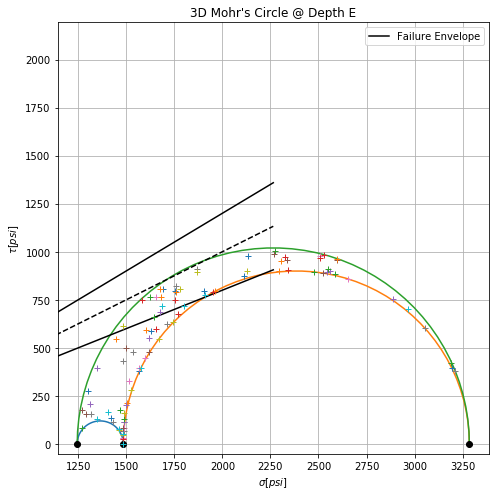

In [20]:
#Let us plot the shear failure envelope

ax = plotMohr3D(a,b,c)

#Plot shear failure envelope

sigN_maxTau = a + (c-a)/2 #Normal stress corresponding to maximum shear stress on Mohrs circle 

mu = 0.5 #friction coefficient
err = 0.1 #uncertainty in friction coefficient value
ax.plot([0,sigN_maxTau ],[0,sigN_maxTau *(mu+err)],'k-',label='Failure Envelope')
ax.plot([0,sigN_maxTau ],[0,sigN_maxTau *(mu)],'k--')
ax.plot([0,sigN_maxTau ],[0,sigN_maxTau *(mu-err)],'k-')


#Plot all the associated stress values on the Mohr's circle as + symbols
for i in range(0,len(dipArray)):
    nDict = calcNVectors(strikeArray[i],dipArray[i])
    t = np.dot(Sg,nDict['n'])
    Sn = np.dot(nDict['n'].T,t) #Total normal stress
    sign = Sn - Pp_E
    tau = np.sqrt(np.linalg.norm(t,2)**2 - Sn**2)
    ax.plot(sign,tau,'+')
ax.legend()

# Any fracture within the failure envelope (so in the plot any + sign within the solid black lines) will be prone to shear slip.
# Those fractures within the envelope (especially those close to the mean) will most likely be hydraulically conductive and those outside will probably not be.


Part 4, Wellbore images actually show that there are two major sets of fractures: 
- Set 1: strike = 60 deg +/- 5 deg, dip = 80 deg +/- 5 deg 
- Set 2: strike = 10 deg +/- 5 deg, dip = 80 deg +/- 5 deg 
Plot results for 10 fractures for each set (errors represent one standard
deviation with normal distribution).
Which fracture set is more likely to slip in shear? Why?

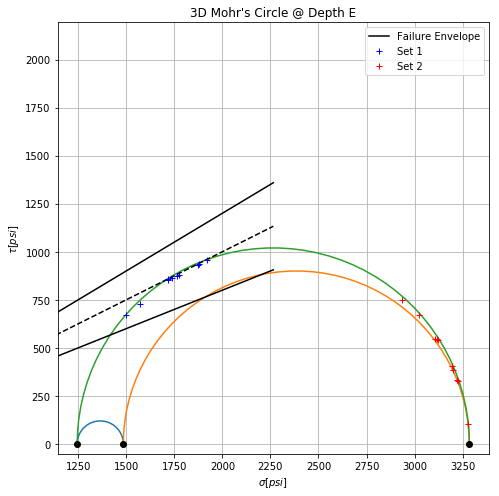

In [21]:
#Bring back Mohr's circle
ax = plotMohr3D(a,b,c)

#Step 1: Sample 10 points from each normal distribution of strike and slip values

numSamples = 10
sigma = 5
set1StrikeArray = np.random.normal(60,sigma,numSamples)
set1DipArray = np.random.normal(80,sigma,numSamples)

set2StrikeArray = np.random.normal(10,sigma,numSamples)
set2DipArray = np.random.normal(80,sigma,numSamples)


ax.plot([0,sigN_maxTau ],[0,sigN_maxTau *(mu+err)],'k-',label='Failure Envelope')
ax.plot([0,sigN_maxTau ],[0,sigN_maxTau *(mu)],'k--')
ax.plot([0,sigN_maxTau ],[0,sigN_maxTau *(mu-err)],'k-')


#Step 2: Plot all the associated stress values on the Mohr's circle as + symbols 
#(set 1 will be blue, set 2 will be red)

for i in range(0,len(set1DipArray)):
    nDict = calcNVectors(set1StrikeArray[i],set1DipArray[i])
    t = np.dot(Sg,nDict['n'])
    Sn = np.dot(nDict['n'].T,t) #Total normal stress
    sign = Sn - Pp_E
    tau = np.sqrt(np.linalg.norm(t,2)**2 - Sn**2)
    if i == 0:
        ax.plot(sign,tau,'b+',label='Set 1')
    else:
        ax.plot(sign,tau,'b+')

for i in range(0,len(set2DipArray)):
    nDict = calcNVectors(set2StrikeArray[i],set2DipArray[i])
    t = np.dot(Sg,nDict['n'])
    Sn = np.dot(nDict['n'].T,t) #Total normal stress
    sign = Sn - Pp_E
    tau = np.sqrt(np.linalg.norm(t,2)**2 - Sn**2)
    if i == 0:
        ax.plot(sign,tau,'r+',label='Set 2')
    else:
        ax.plot(sign,tau,'r+')
ax.legend()

# Since set 1 falls under the shear failure envelope we setup earlier, it is likely to be the most hydraulically conductive and prone towards slip in shear.

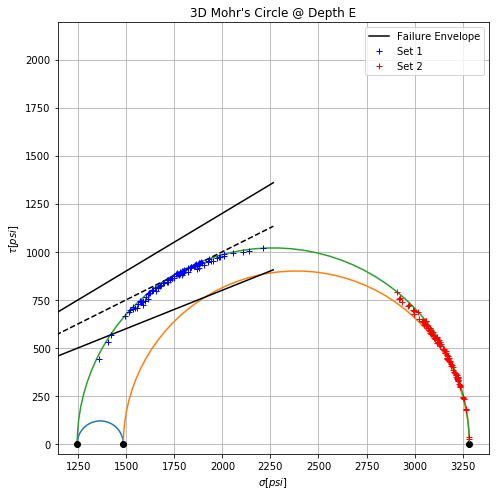

In [23]:
#Difficult to see at 10 samples, increasing to 100

#Bring back Mohr's circle
ax = plotMohr3D(a,b,c)

#Step 1: Sample 10 points from each normal distribution of strike and slip values

numSamples = 100
sigma = 5
set1StrikeArray = np.random.normal(60,sigma,numSamples)
set1DipArray = np.random.normal(80,sigma,numSamples)

set2StrikeArray = np.random.normal(10,sigma,numSamples)
set2DipArray = np.random.normal(80,sigma,numSamples)


ax.plot([0,sigN_maxTau ],[0,sigN_maxTau *(mu+err)],'k-',label='Failure Envelope')
ax.plot([0,sigN_maxTau ],[0,sigN_maxTau *(mu)],'k--')
ax.plot([0,sigN_maxTau ],[0,sigN_maxTau *(mu-err)],'k-')


#Step 2: Plot all the associated stress values on the Mohr's circle as + symbols 
#(set 1 will be blue, set 2 will be red)

for i in range(0,len(set1DipArray)):
    nDict = calcNVectors(set1StrikeArray[i],set1DipArray[i])
    t = np.dot(Sg,nDict['n'])
    Sn = np.dot(nDict['n'].T,t) #Total normal stress
    sign = Sn - Pp_E
    tau = np.sqrt(np.linalg.norm(t,2)**2 - Sn**2)
    if i == 0:
        ax.plot(sign,tau,'b+',label='Set 1')
    else:
        ax.plot(sign,tau,'b+')

for i in range(0,len(set2DipArray)):
    nDict = calcNVectors(set2StrikeArray[i],set2DipArray[i])
    t = np.dot(Sg,nDict['n'])
    Sn = np.dot(t.T,nDict['n']) #Total normal stress
    sign = Sn - Pp_E
    tau = np.sqrt(np.linalg.norm(t,2)**2 - Sn**2)
    if i == 0:
        ax.plot(sign,tau,'r+',label='Set 2')
    else:
        ax.plot(sign,tau,'r+')
ax.legend()